# CSCE 636: Deep Learning
# UIN: 828002068
# Name: Mamoon Masud
# Submission - 8 
# Architecture - Transfer Learning ( Inception-v1 Inflated 3D ConvNet )
# Activity Recognition Project - Training Code

"""Reference Paper: Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
Joao Carreira, Andrew Zisserman
https://arxiv.org/abs/1705.07750v1
"""

In [27]:
from __future__ import print_function
from __future__ import absolute_import

import warnings

import numpy as np

from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D
from keras import models
from keras.layers.convolutional import MaxPooling3D, Conv3D
from keras.layers.recurrent import LSTM
from keras.layers import Reshape

from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import plot_model
from keras import backend as K
import numpy as np
import argparse
import os
import glob
import keras
from keras_video import VideoFrameGenerator


In [11]:
WEIGHTS_NAME = ['rgb_kinetics_only', 'flow_kinetics_only', 'rgb_imagenet_and_kinetics', 'flow_imagenet_and_kinetics']

# path to pretrained models with top (classification layer)
WEIGHTS_PATH = {
    'rgb_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels.h5',
    'flow_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels.h5',
    'rgb_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels.h5',
    'flow_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels.h5'
}

# path to pretrained models with no top (no classification layer)
WEIGHTS_PATH_NO_TOP = {
    'rgb_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_kinetics_only' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'rgb_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_imagenet_and_kinetics' : 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5'
}

In [2]:
def _obtain_input_shape(input_shape,
                        default_frame_size,
                        min_frame_size,
                        default_num_frames,
                        min_num_frames,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate the model's input shape.
    (Adapted from `keras/applications/imagenet_utils.py`)

    # Arguments
        input_shape: either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_frame_size: default input frames(images) width/height for the model.
        min_frame_size: minimum input frames(images) width/height accepted by the model.
        default_num_frames: default input number of frames(images) for the model.
        min_num_frames: minimum input number of frames accepted by the model.
        data_format: image data format to use.
        require_flatten: whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: one of `None` (random initialization)
            or 'kinetics_only' (pre-training on Kinetics dataset).
            or 'imagenet_and_kinetics' (pre-training on ImageNet and Kinetics datasets).
            If weights='kinetics_only' or weights=='imagenet_and_kinetics' then
            input channels must be equal to 3.

    # Returns
        An integer shape tuple (may include None entries).

    # Raises
        ValueError: in case of invalid argument values.
    """
    if weights != 'kinetics_only' and weights != 'imagenet_and_kinetics' and input_shape and len(input_shape) == 4:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_num_frames, default_frame_size, default_frame_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_num_frames, default_frame_size, default_frame_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_num_frames, default_frame_size, default_frame_size)
        else:
            default_shape = (default_num_frames, default_frame_size, default_frame_size, 3)
    if (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics') and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting`include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape

    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 4:
                    raise ValueError(
                        '`input_shape` must be a tuple of four integers.')
                if input_shape[0] != 3 and (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics'):
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if input_shape[1] is not None and input_shape[1] < min_num_frames:
                    raise ValueError('Input number of frames must be at least ' +
                                     str(min_num_frames) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if ((input_shape[2] is not None and input_shape[2] < min_frame_size) or
                   (input_shape[3] is not None and input_shape[3] < min_frame_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_frame_size) + 'x' + str(min_frame_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 4:
                    raise ValueError(
                        '`input_shape` must be a tuple of four integers.')
                if input_shape[-1] != 3 and (weights == 'kinetics_only' or weights == 'imagenet_and_kinetics'):
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if input_shape[0] is not None and input_shape[0] < min_num_frames:
                    raise ValueError('Input number of frames must be at least ' +
                                     str(min_num_frames) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')

                if ((input_shape[1] is not None and input_shape[1] < min_frame_size) or
                   (input_shape[2] is not None and input_shape[2] < min_frame_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_frame_size) + 'x' + str(min_frame_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None, None)
            else:
                input_shape = (None, None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [3]:
def conv3d_bn(x,
              filters,
              num_frames,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1, 1),
              use_bias = False,
              use_activation_fn = True,
              use_bn = True,
              name=None):
    """Utility function to apply conv3d + BN.

    # Arguments
        x: input tensor.
        filters: filters in `Conv3D`.
        num_frames: frames (time depth) of the convolution kernel.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv3D`.
        strides: strides in `Conv3D`.
        use_bias: use bias or not  
        use_activation_fn: use an activation function or not.
        use_bn: use batch normalization or not.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.

    # Returns
        Output tensor after applying `Conv3D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv3D(
        filters, (num_frames, num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=use_bias,
        name=conv_name)(x)

    if use_bn:
        if K.image_data_format() == 'channels_first':
            bn_axis = 1
        else:
            bn_axis = 4
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)

    if use_activation_fn:
        x = Activation('relu', name=name)(x)

    return x

In [4]:
# Function for generating the I3D Model.
def Inception_Inflated3d(include_top=True,
                weights=None,
                input_tensor=None,
                input_shape=None,
                dropout_prob=0.0,
                endpoint_logit=True,
                classes=400):
    """Instantiates the Inflated 3D Inception v1 architecture.

    Optionally loads weights pre-trained
    on Kinetics. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format='channels_last'` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    Note that the default input frame(image) size for this model is 224x224.

    # Arguments
        include_top: whether to include the the classification 
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or 'kinetics_only' (pre-training on Kinetics dataset only).
            or 'imagenet_and_kinetics' (pre-training on ImageNet and Kinetics datasets).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(NUM_FRAMES, 224, 224, 3)` (with `channels_last` data format)
            or `(NUM_FRAMES, 3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
            NUM_FRAMES should be no smaller than 8. The authors used 64
            frames per example for training and testing on kinetics dataset
            Also, Width and height should be no smaller than 32.
            E.g. `(64, 150, 150, 3)` would be one valid value.
        dropout_prob: optional, dropout probability applied in dropout layer
            after global average pooling layer. 
            0.0 means no dropout is applied, 1.0 means dropout is applied to all features.
            Note: Since Dropout is applied just before the classification
            layer, it is only useful when `include_top` is set to True.
        endpoint_logit: (boolean) optional. If True, the model's forward pass
            will end at producing logits. Otherwise, softmax is applied after producing
            the logits to produce the class probabilities prediction. Setting this parameter 
            to True is particularly useful when you want to combine results of rgb model
            and optical flow model.
            - `True` end model forward pass at logit output
            - `False` go further after logit to produce softmax predictions
            Note: This parameter is only useful when `include_top` is set to True.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if not (weights in WEIGHTS_NAME or weights is None or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or %s' % 
                         str(WEIGHTS_NAME) + ' ' 
                         'or a valid path to a file containing `weights` values')

    if weights in WEIGHTS_NAME and include_top and classes != 400:
        raise ValueError('If using `weights` as one of these %s, with `include_top`'
                         ' as true, `classes` should be 400' % str(WEIGHTS_NAME))

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_frame_size=224, 
        min_frame_size=32, 
        default_num_frames=64,
        min_num_frames=8,
        data_format=K.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 4

    # Downsampling via convolution (spatial and temporal)
    x = conv3d_bn(img_input, 64, 7, 7, 7, strides=(2, 2, 2), padding='same', name='Conv3d_1a_7x7')

    # Downsampling (spatial only)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_2a_3x3')(x)
    x = conv3d_bn(x, 64, 1, 1, 1, strides=(1, 1, 1), padding='same', name='Conv3d_2b_1x1')
    x = conv3d_bn(x, 192, 3, 3, 3, strides=(1, 1, 1), padding='same', name='Conv3d_2c_3x3')

    # Downsampling (spatial only)
    x = MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_3a_3x3')(x)

    # Mixed 3b
    branch_0 = conv3d_bn(x, 64, 1, 1, 1, padding='same', name='Conv3d_3b_0a_1x1')

    branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_3b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 128, 3, 3, 3, padding='same', name='Conv3d_3b_1b_3x3')

    branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_3b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 32, 3, 3, 3, padding='same', name='Conv3d_3b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 32, 1, 1, 1, padding='same', name='Conv3d_3b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_3b')

    # Mixed 3c
    branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_0a_1x1')

    branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 192, 3, 3, 3, padding='same', name='Conv3d_3c_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_3c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 96, 3, 3, 3, padding='same', name='Conv3d_3c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_3c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_3c')


    # Downsampling (spatial and temporal)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same', name='MaxPool2d_4a_3x3')(x)

    # Mixed 4b
    branch_0 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_4b_0a_1x1')

    branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_4b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 208, 3, 3, 3, padding='same', name='Conv3d_4b_1b_3x3')

    branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_4b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 48, 3, 3, 3, padding='same', name='Conv3d_4b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4b')

    # Mixed 4c
    branch_0 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4c_0a_1x1')

    branch_1 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 224, 3, 3, 3, padding='same', name='Conv3d_4c_1b_3x3')

    branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4c')

    # Mixed 4d
    branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_0a_1x1')

    branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 256, 3, 3, 3, padding='same', name='Conv3d_4d_1b_3x3')

    branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4d_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4d_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4d_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4d_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4d')

    # Mixed 4e
    branch_0 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4e_0a_1x1')

    branch_1 = conv3d_bn(x, 144, 1, 1, 1, padding='same', name='Conv3d_4e_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 288, 3, 3, 3, padding='same', name='Conv3d_4e_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4e_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4e_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4e_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4e_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4e')

    # Mixed 4f
    branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_4f_0a_1x1')

    branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4f_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_4f_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4f_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_4f_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4f_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_4f_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_4f')


    # Downsampling (spatial and temporal)
    x = MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same', name='MaxPool2d_5a_2x2')(x)

    # Mixed 5b
    branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_5b_0a_1x1')

    branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_5b_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_5b_1b_3x3')

    branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_5b_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5b_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5b_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5b_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_5b')

    # Mixed 5c
    branch_0 = conv3d_bn(x, 384, 1, 1, 1, padding='same', name='Conv3d_5c_0a_1x1')

    branch_1 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_5c_1a_1x1')
    branch_1 = conv3d_bn(branch_1, 384, 3, 3, 3, padding='same', name='Conv3d_5c_1b_3x3')

    branch_2 = conv3d_bn(x, 48, 1, 1, 1, padding='same', name='Conv3d_5c_2a_1x1')
    branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5c_2b_3x3')

    branch_3 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5c_3a_3x3')(x)
    branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5c_3b_1x1')

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name='Mixed_5c')

    if include_top:
        # Classification block
        x = AveragePooling3D((2, 7, 7), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)
        x = Dropout(dropout_prob)(x)

        x = conv3d_bn(x, classes, 1, 1, 1, padding='same', 
                use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')
 
        num_frames_remaining = int(x.shape[1])
        x = Reshape((num_frames_remaining, 2))(x)

        # logits (raw scores for each class)
        x = Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
                   output_shape=lambda s: (s[0], s[2]))(x)

        if not endpoint_logit:
            x = Activation('softmax', name='prediction')(x)
    else:
        h = int(x.shape[2])
        w = int(x.shape[3])
        x = AveragePooling3D((2, h, w), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)



    inputs = img_input
    # create model
    model = Model(inputs, x, name='i3d_inception')

    # load weights
    if weights in WEIGHTS_NAME:
        if weights == WEIGHTS_NAME[0]:   # rgb_kinetics_only
            if include_top:
                weights_url = WEIGHTS_PATH['rgb_kinetics_only']
                model_name = 'i3d_inception_rgb_kinetics_only.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['rgb_kinetics_only']
                model_name = 'i3d_inception_rgb_kinetics_only_no_top.h5'

        elif weights == WEIGHTS_NAME[1]: # flow_kinetics_only
            if include_top:
                weights_url = WEIGHTS_PATH['flow_kinetics_only']
                model_name = 'i3d_inception_flow_kinetics_only.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['flow_kinetics_only']
                model_name = 'i3d_inception_flow_kinetics_only_no_top.h5'

        elif weights == WEIGHTS_NAME[2]: # rgb_imagenet_and_kinetics
            if include_top:
                weights_url = WEIGHTS_PATH['rgb_imagenet_and_kinetics']
                model_name = 'i3d_inception_rgb_imagenet_and_kinetics.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['rgb_imagenet_and_kinetics']
                model_name = 'i3d_inception_rgb_imagenet_and_kinetics_no_top.h5'

        elif weights == WEIGHTS_NAME[3]: # flow_imagenet_and_kinetics
            if include_top:
                weights_url = WEIGHTS_PATH['flow_imagenet_and_kinetics']
                model_name = 'i3d_inception_flow_imagenet_and_kinetics.h5'
            else:
                weights_url = WEIGHTS_PATH_NO_TOP['flow_imagenet_and_kinetics']
                model_name = 'i3d_inception_flow_imagenet_and_kinetics_no_top.h5'

        downloaded_weights_path = get_file(model_name, weights_url, cache_subdir='models')
        model.load_weights(downloaded_weights_path)

        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first' and K.backend() == 'tensorflow':
            warnings.warn('You are using the TensorFlow backend, yet you '
                          'are using the Theano '
                          'image data format convention '
                          '(`image_data_format="channels_first"`). '
                          'For best performance, set '
                          '`image_data_format="channels_last"` in '
                          'your keras config '
                          'at ~/.keras/keras.json.')

    elif weights is not None:
        model.load_weights(weights)

    return model

In [6]:
NUM_FRAMES = 15
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
NUM_RGB_CHANNELS = 3
#NUM_FLOW_CHANNELS = 2
NUM_CLASSES = 2

# Building the RGB Model with pretrained weights (Pre-trained on Imagenet and Kinetics Dataset)

In [12]:
rgb_model_1 = Inception_Inflated3d(
                include_top=False,
                weights='rgb_imagenet_and_kinetics',
                input_shape=(NUM_FRAMES, FRAME_HEIGHT, FRAME_WIDTH, NUM_RGB_CHANNELS),
                classes=2)

In [14]:
# Uncomment to view the Model Plot
#plot_model(rgb_model_1, to_file='rgb_model.png', show_shapes=True, show_layer_names=True)

In [16]:
# Adding more layers for classification 
classes=2
dropout_prob = 0.3
model = models.Sequential()
model.add(rgb_model_1)
model.add(Dropout(dropout_prob))
model.add(Conv3D(200,( 1, 1, 1), padding='same', 
            use_bias=True, activation=None, name='Conv3d_6a_1x1'))
num_frames_remaining = int(model.output_shape[1])
model.add(Reshape((num_frames_remaining, 200)))

In [17]:
model.add(LSTM(64, return_sequences=False, dropout=0.5))
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(2, activation='softmax'))

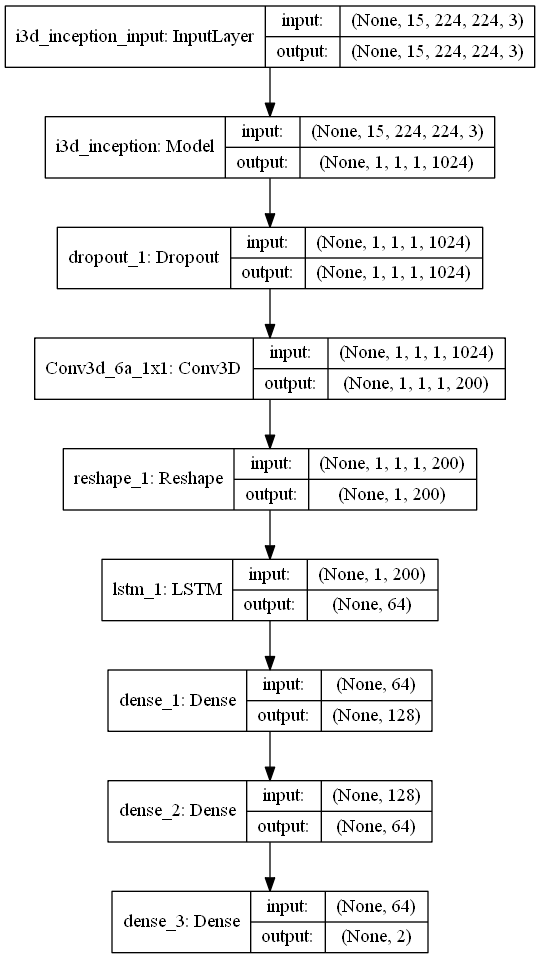

In [18]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
i3d_inception (Model)        (None, 1, 1, 1, 1024)     12294544  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 1, 1024)     0         
_________________________________________________________________
Conv3d_6a_1x1 (Conv3D)       (None, 1, 1, 1, 200)      205000    
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [21]:
## Saving the Model Architecture to be loaded later for prediction or testing evaluation
#with open('/content/drive/My Drive/DL Proj/sub_4/ver_4_model_architecture.json', 'w') as f:
#    f.write(model.to_json())

print('This is the number of trainable weights '
      'before freezing the I3D-Kinetics Layers:', len(model.trainable_weights))

This is the number of trainable weights before freezing the I3D-Kinetics Layers: 125


In [22]:
#Freezing the weights of the Kinetics I3D
rgb_model_1.trainable = False

In [23]:
print('This is the number of trainable weights '
      'after freezing the I3D-Kinetics Layers:', len(model.trainable_weights))

This is the number of trainable weights after freezing the I3D-Kinetics Layers: 11


In [24]:
from keras.optimizers import Adam, RMSprop
optimizer = Adam(lr=1e-5, decay=1e-6)

model.compile(optimizer=optimizer , 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# Uncomment to install Keras-Video Generator to be used for training the model 
#!pip install keras-video-generators

# Instantiating the video generator object. 

In [28]:
# use sub directories names as classes
classes = ['Door', 'Not-Door']
classes.sort()
# some global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 15
BS = 5
# pattern to get videos and classes
glob_pattern='/Path of the Training Set/{classname}/*.mp4'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.25,  # 33% of the videos will be used as validation set. 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

class Door, validation count: 0, train count: 0
class Not-Door, validation count: 0, train count: 0
Total data: 2 classes for 0 files for train


In [49]:
valid = train.get_validation_generator()

Total data: 2 classes for 86 files for validation


In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import os.path
import time

early_stopper = EarlyStopping(patience=5)
#tb = TensorBoard(log_dir=os.path.join('F:\DLProj\ver4', 'logs'))
timestamp = time.time()
csv_logger =  CSVLogger(os.path.join('/content/drive/My Drive/DL Proj/sub_4/logs', 'logs' + '-' + 'training-' + \
                        str(timestamp) + '.log'))
checkpoint = ModelCheckpoint('/content/drive/My Drive/DL Proj/sub_4/Models_1/T3D_saved_model_weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
                              verbose=1, mode='min',  ) #save_best_only=True, save_weights_only=True)

# Create a TensorBoard logger
tb = TensorBoard(
    log_dir='logs',
    write_graph=True,
    histogram_freq=5)

callbacks_list =[csv_logger, checkpoint]

In [53]:
history = model.fit_generator(
                    train, 
                    validation_data= valid, 
                    #batch_size= 5,
                    verbose=1,
                    callbacks= callbacks_list,
                    epochs = 50)

Epoch 1/50
52/52 [==============================] - 230s 4s/step - loss: 0.6916 - accuracy: 0.5462 - val_loss: 0.6856 - val_accuracy: 0.4588

Epoch 00001: saving model to /content/drive/My Drive/DL Proj/sub_4/Models/T3D_saved_model_weights.01-0.69.hdf5
Epoch 2/50
52/52 [==============================] - 37s 712ms/step - loss: 0.6927 - accuracy: 0.5077 - val_loss: 0.6913 - val_accuracy: 0.4588

Epoch 00002: saving model to /content/drive/My Drive/DL Proj/sub_4/Models/T3D_saved_model_weights.02-0.69.hdf5
Epoch 3/50
52/52 [==============================] - 41s 792ms/step - loss: 0.6912 - accuracy: 0.5385 - val_loss: 0.6996 - val_accuracy: 0.4941

Epoch 00003: saving model to /content/drive/My Drive/DL Proj/sub_4/Models/T3D_saved_model_weights.03-0.70.hdf5
Epoch 4/50
52/52 [==============================] - 41s 790ms/step - loss: 0.6912 - accuracy: 0.5577 - val_loss: 0.6881 - val_accuracy: 0.5176

Epoch 00004: saving model to /content/drive/My Drive/DL Proj/sub_4/Models/T3D_saved_model_wei

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


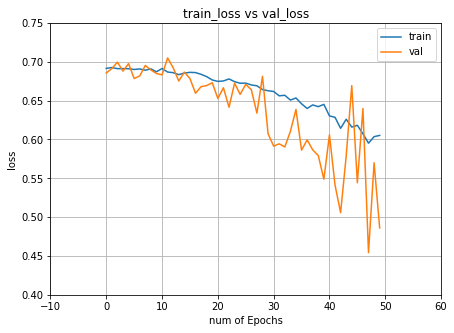

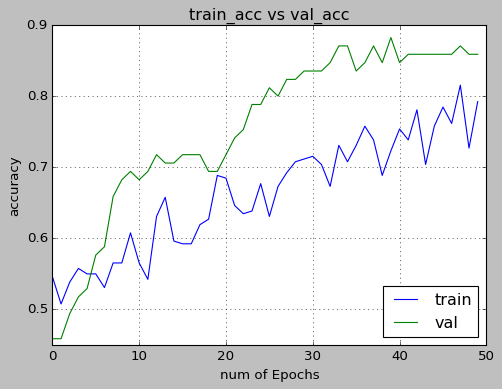

In [55]:
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
xc=range(50)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print (plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [ ]:
## Continuing training for 100 more epochs
model.load_weights('/content/drive/My Drive/DL Proj/sub_4/Models/T3D_saved_model_weights.50-0.49.hdf5')


In [59]:
history = model.fit_generator(
                    train, 
                    validation_data= valid, 
                    #batch_size= 5,
                    verbose=1,
                    callbacks= callbacks_list,
                    epochs = 100)

Epoch 1/100
52/52 [==============================] - 43s 819ms/step - loss: 0.5987 - accuracy: 0.7538 - val_loss: 0.4862 - val_accuracy: 0.8588

Epoch 00001: saving model to /content/drive/My Drive/DL Proj/sub_4/Models_1/T3D_saved_model_weights.01-0.49.hdf5
Epoch 2/100
52/52 [==============================] - 41s 784ms/step - loss: 0.5914 - accuracy: 0.7808 - val_loss: 0.4631 - val_accuracy: 0.8706

Epoch 00002: saving model to /content/drive/My Drive/DL Proj/sub_4/Models_1/T3D_saved_model_weights.02-0.46.hdf5
Epoch 3/100
52/52 [==============================] - 40s 777ms/step - loss: 0.5705 - accuracy: 0.7846 - val_loss: 0.4568 - val_accuracy: 0.8588

Epoch 00003: saving model to /content/drive/My Drive/DL Proj/sub_4/Models_1/T3D_saved_model_weights.03-0.46.hdf5
Epoch 4/100
52/52 [==============================] - 40s 774ms/step - loss: 0.5716 - accuracy: 0.7731 - val_loss: 0.4666 - val_accuracy: 0.8824

Epoch 00004: saving model to /content/drive/My Drive/DL Proj/sub_4/Models_1/T3D_s